In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define Sinkhorn Divergence

In [2]:
def lse(V):
    v_m = torch.max(V, dim=1, keepdim=True).values
    return v_m + (V - v_m).exp().sum(dim=1, keepdim=True).log()

def sink_maps(x, y, eps, p):
    C = torch.norm(x.unsqueeze(1) - y.unsqueeze(0), dim=2, p=p) / eps
    S_f = lambda g: -lse(g.view(1, -1) - C)
    S_g = lambda f: -lse(f.view(1, -1) - C.T)
    return S_f, S_g

def sink(a, x, b, y, p=2, eps=1, iter=100, tol=1e-3, converge=True):
    a_log, b_log = a.log(), b.log()
    f, g = torch.zeros_like(a), torch.zeros_like(b)
    S_f, S_g = sink_maps(x, y, eps, p)
    with torch.set_grad_enabled(not converge):
        for i in range(iter):
            g_old = g
            f = S_f(g + b_log)
            g = S_g(f + a_log)
            if eps * (g - g_old).abs().mean() < tol: break
    if not converge:
        return eps * S_f(g + b_log), eps * S_g(f + a_log)
    else:
        S_f, _ = sink_maps(x.detach(), y, eps, p)
        _, S_g = sink_maps(x, y.detach(), eps, p)
        return eps * S_f((g + b_log).detach()), eps * S_g((f + a_log).detach())

def entropic_ot(a, x, b, y, **kwargs):
    f, g = sink(a, x, b, y, **kwargs)
    return f.T @ a + g.T @ b

def sinkhorn_divergence(a, x, b, y, **kwargs):
    return entropic_ot(a, x, b, y, **kwargs) \
        - 0.5 * entropic_ot(a, x, a, x, **kwargs) \
        - 0.5 * entropic_ot(b, y, b, y, **kwargs)

# 2D Ambient Space
## Generate Data

In [45]:
x = torch.rand(100, 1) - 0.5
y = x ** 3
dataset_1D = torch.hstack([x, y])

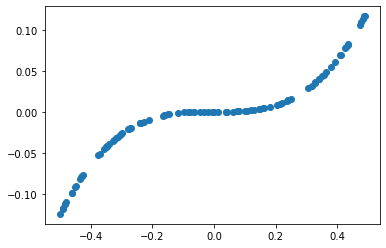

In [46]:
plt.scatter(x, y)
plt.gca().set_aspect('auto')
plt.show()

## Define Generator

In [19]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, in_features=2, out_feature=2, width=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, width),
            nn.BatchNorm1d(width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.BatchNorm1d(width),
            nn.ReLU(),
            nn.Linear(width, out_feature)
        )
    
    def forward(self, input):
        return self.model(input)

## Train
### Submersion $2\to 1$

Epoch: 0 	 Sinkhorn Divergence: 0.197566


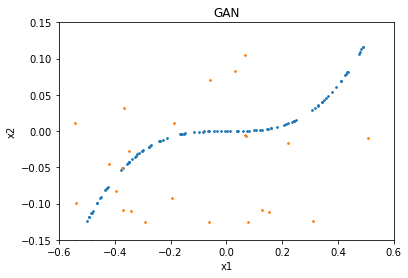

Epoch: 5000 	 Sinkhorn Divergence: 0.007084


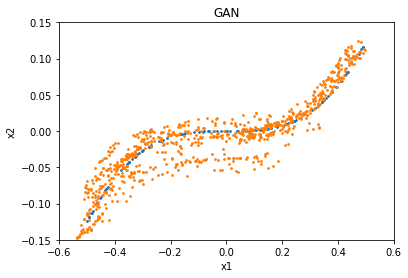

Epoch: 10000 	 Sinkhorn Divergence: 0.015059


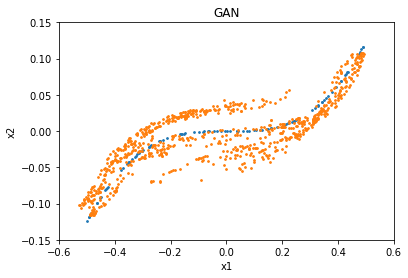

Epoch: 15000 	 Sinkhorn Divergence: 0.005210


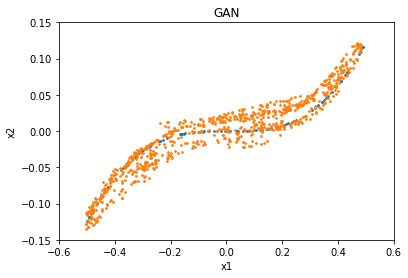

Epoch: 20000 	 Sinkhorn Divergence: 0.006458


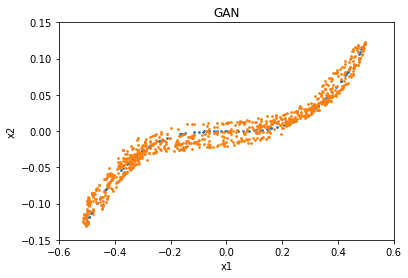

Epoch: 25000 	 Sinkhorn Divergence: 0.002702


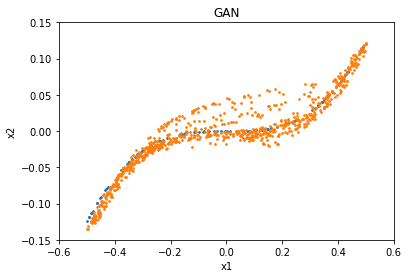

Epoch: 30000 	 Sinkhorn Divergence: 0.005464


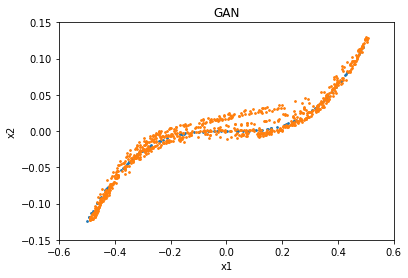

Epoch: 35000 	 Sinkhorn Divergence: 0.007595


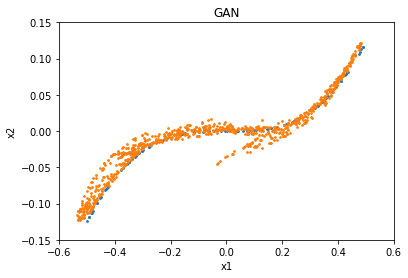

Epoch: 40000 	 Sinkhorn Divergence: 0.006377


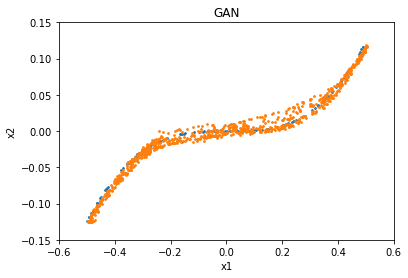

Epoch: 45000 	 Sinkhorn Divergence: 0.004604


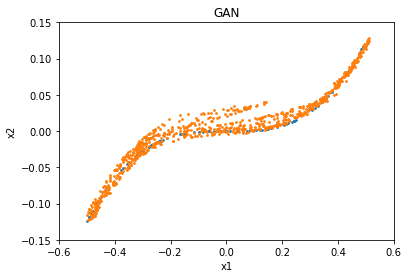

Epoch: 49999 	 Sinkhorn Divergence: 0.007463


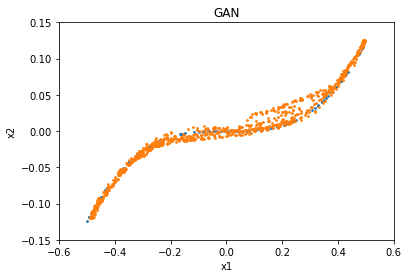

In [47]:
from torch.utils.data import DataLoader
from torch.optim import Adam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = dataset_1D

epochs = 50000
batch_size = 100
latent_size = 2
out_feature = 2
width = 1024

dataloader = DataLoader(
    dataset.to(device), 
    batch_size, shuffle=True
    )
generator = Generator(latent_size, out_feature, width).to(device)
optimizer = Adam(generator.parameters(), lr=3e-4)


for epoch in range(epochs):
    for batch in dataloader:
        optimizer.zero_grad()
        loss = sinkhorn_divergence(
            torch.ones(len(batch), 1, device=device) / len(batch), 
            batch, 
            torch.ones(len(batch), 1, device=device) / len(batch), 
            generator(torch.rand(len(batch), latent_size, device=device)),
            eps=0.05, iter=1000
            )
        loss.backward()
        optimizer.step()

    if epoch % 5000 == 0 or epoch == epochs-1:
        print('Epoch: {} \t Sinkhorn Divergence: {:4f}'.format(epoch, loss.item()))
        record = generator(torch.rand(800, latent_size, device=device)).cpu().detach().numpy()
        plt.scatter(dataset[:, 0], dataset[:, 1], s=3)
        plt.scatter(record[:, 0], record[:, 1], s=3)
        plt.xlim(-0.6, 0.6); plt.ylim(-0.15, 0.15)
        plt.title('GAN')
        plt.xlabel('x1')
        plt.ylabel('x2')
        # plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

### Sinkhorn MI

Epoch: 0 	 Sinkhorn Divergence: 0.321335


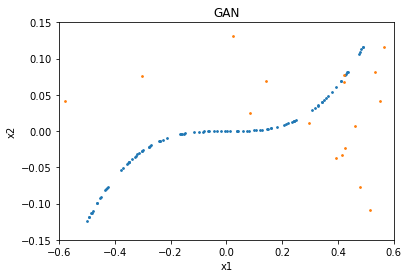

Epoch: 5000 	 Sinkhorn Divergence: 0.042353


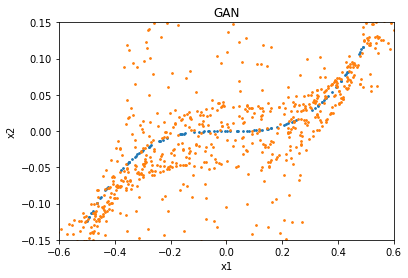

Epoch: 10000 	 Sinkhorn Divergence: 0.055635


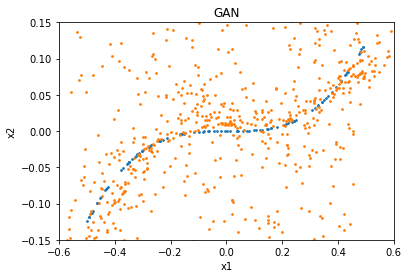

Epoch: 15000 	 Sinkhorn Divergence: 0.061643


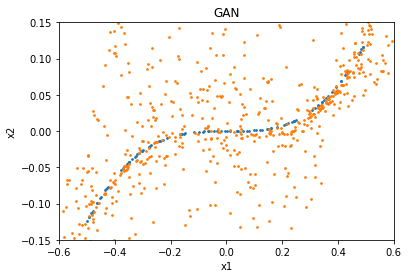

Epoch: 20000 	 Sinkhorn Divergence: 0.066124


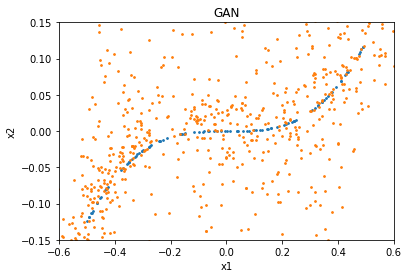

Epoch: 25000 	 Sinkhorn Divergence: 0.043953


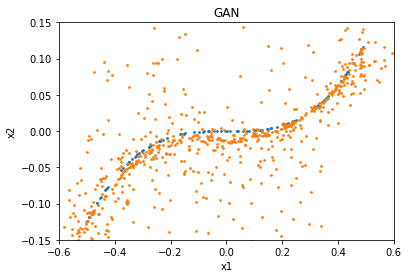

Epoch: 30000 	 Sinkhorn Divergence: 0.040070


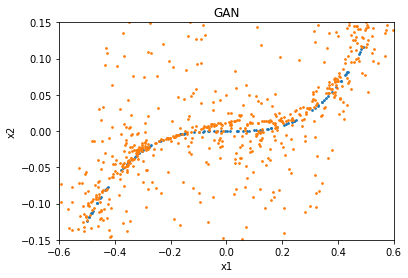

Epoch: 35000 	 Sinkhorn Divergence: 0.040251


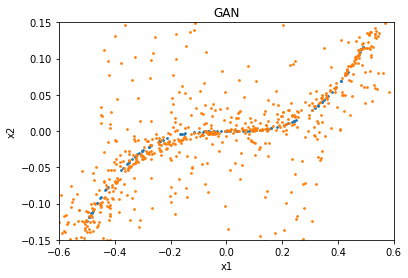

Epoch: 40000 	 Sinkhorn Divergence: 0.044452


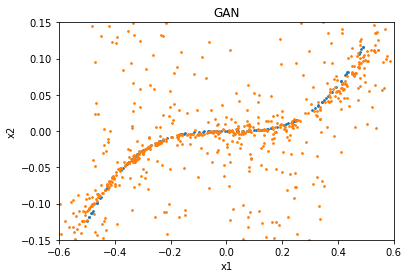

Epoch: 45000 	 Sinkhorn Divergence: 0.046116


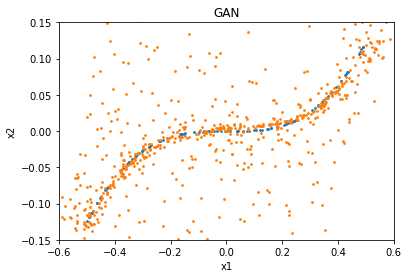

Epoch: 49999 	 Sinkhorn Divergence: 0.043618


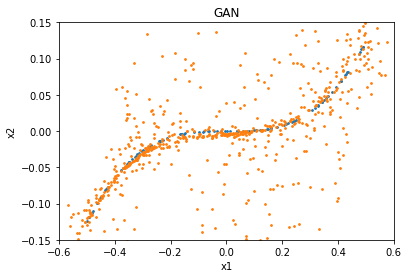

In [48]:
from torch.utils.data import DataLoader
from torch.optim import Adam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = dataset_1D

epochs = 50000
batch_size = 100
latent_size = 2
out_feature = 2
width = 1024
eps = 0.05

dataloader = DataLoader(
    dataset.to(device), 
    batch_size, shuffle=True
    )
generator = Generator(latent_size, out_feature, width).to(device)
optimizer = Adam(generator.parameters(), lr=3e-4)


for epoch in range(epochs):
    for batch in dataloader:
        optimizer.zero_grad()
        noise = torch.rand(len(batch), latent_size, device=device)
        pred = generator(noise)
        sinkd = sinkhorn_divergence(
            torch.ones(len(batch), 1, device=device) / len(batch), 
            batch, 
            torch.ones(len(batch), 1, device=device) / len(batch), 
            pred,
            eps=eps, iter=1000
            )
        sinkm = - sinkhorn_divergence(
            torch.ones(batch_size, 1, device=device) / batch_size, 
            torch.hstack([noise[torch.randperm(len(noise))], pred]),
            torch.ones(batch_size, 1, device=device) / batch_size, 
            torch.hstack([noise, pred]),
            eps=eps, iter=1000
            )
        loss = sinkd + sinkm
        loss.backward()
        optimizer.step()

    if epoch % 5000 == 0 or epoch == epochs-1:
        print('Epoch: {} \t Sinkhorn Divergence: {:4f}'.format(epoch, sinkd.item()))
        record = generator(torch.rand(800, latent_size, device=device)).cpu().detach().numpy()
        plt.scatter(dataset[:, 0], dataset[:, 1], s=3)
        plt.scatter(record[:, 0], record[:, 1], s=3)
        plt.xlim(-0.6, 0.6); plt.ylim(-0.15, 0.15)
        plt.title('GAN')
        plt.xlabel('x1')
        plt.ylabel('x2')
        # plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

### Map $1\to 1$

Epoch: 0 	 Sinkhorn Divergence: 0.241734


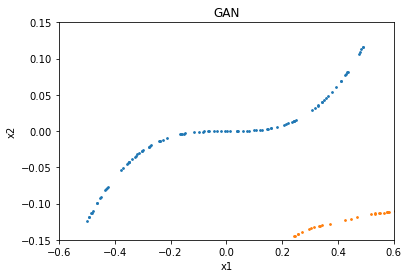

Epoch: 5000 	 Sinkhorn Divergence: 0.013838


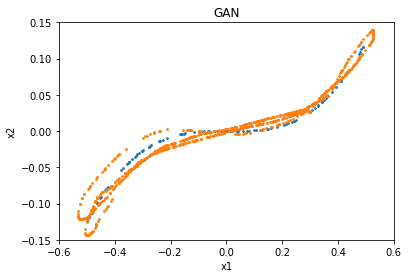

Epoch: 10000 	 Sinkhorn Divergence: 0.007744


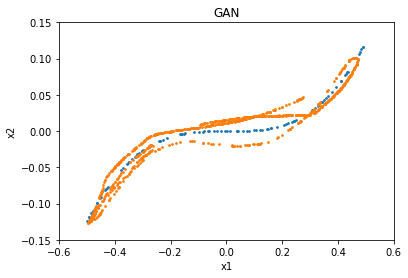

Epoch: 15000 	 Sinkhorn Divergence: 0.014798


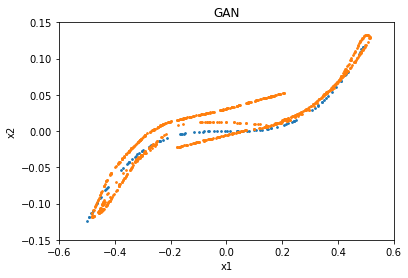

Epoch: 20000 	 Sinkhorn Divergence: 0.010238


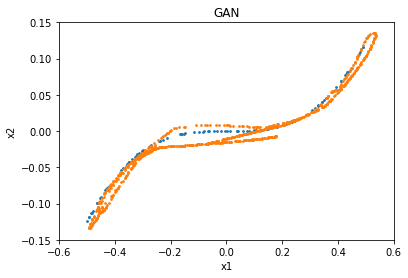

Epoch: 25000 	 Sinkhorn Divergence: 0.010738


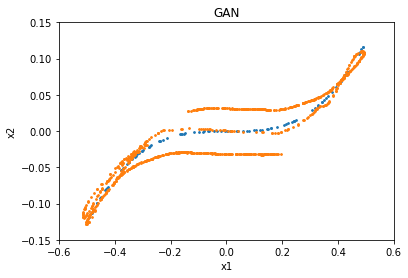

Epoch: 30000 	 Sinkhorn Divergence: 0.005582


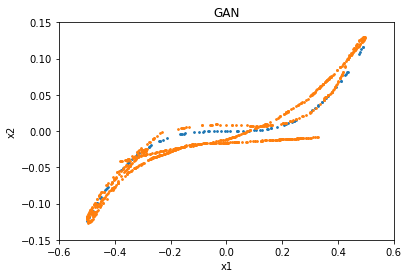

Epoch: 35000 	 Sinkhorn Divergence: 0.011549


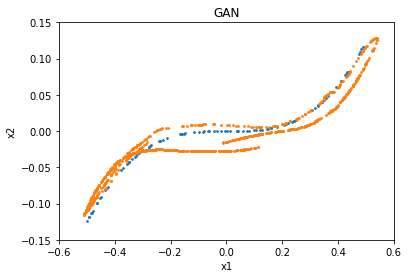

Epoch: 40000 	 Sinkhorn Divergence: 0.007421


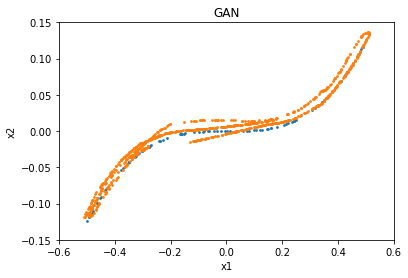

Epoch: 45000 	 Sinkhorn Divergence: 0.006649


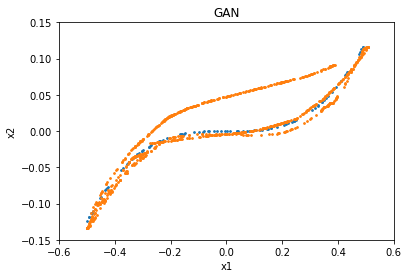

Epoch: 49999 	 Sinkhorn Divergence: 0.006099


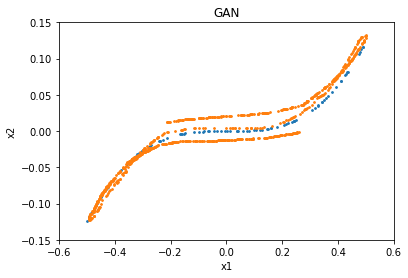

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 50000
batch_size = 100
latent_size = 1
out_feature = 2
width = 1024

dataloader = DataLoader(
    dataset.to(device), 
    batch_size, shuffle=True
    )
generator = Generator(latent_size, out_feature, width).to(device)
optimizer = Adam(generator.parameters(), lr=3e-4)


for epoch in range(epochs):
    for batch in dataloader:
        optimizer.zero_grad()
        loss = sinkhorn_divergence(
            torch.ones(len(batch), 1, device=device) / len(batch), 
            batch, 
            torch.ones(len(batch), 1, device=device) / len(batch), 
            generator(torch.rand(len(batch), latent_size, device=device)),
            eps=0.05, iter=1000
            )
        loss.backward()
        optimizer.step()

    if epoch % 5000 == 0 or epoch == epochs-1:
        print('Epoch: {} \t Sinkhorn Divergence: {:4f}'.format(epoch, loss.item()))
        record = generator(torch.rand(800, latent_size, device=device)).cpu().detach().numpy()
        plt.scatter(dataset[:, 0], dataset[:, 1], s=3)
        plt.scatter(record[:, 0], record[:, 1], s=3)
        plt.xlim(-0.6, 0.6); plt.ylim(-0.15, 0.15)
        plt.title('GAN')
        plt.xlabel('x1')
        plt.ylabel('x2')
        # plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

Epoch: 0 	 Sinkhorn Divergence: 0.481045


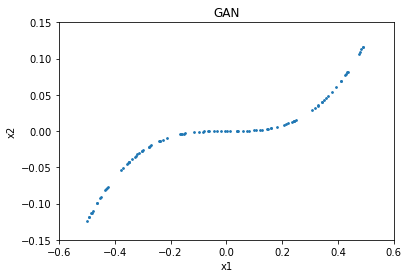

Epoch: 5000 	 Sinkhorn Divergence: 0.008603


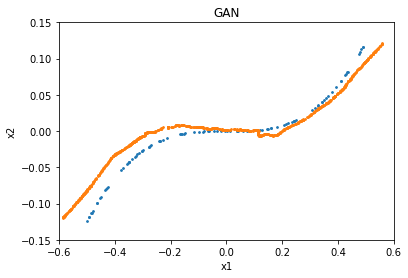

Epoch: 10000 	 Sinkhorn Divergence: 0.014444


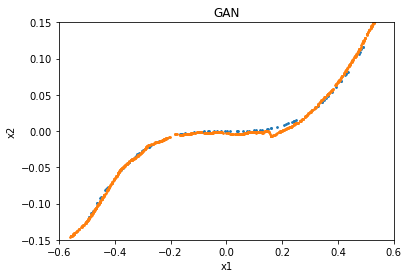

Epoch: 15000 	 Sinkhorn Divergence: 0.012496


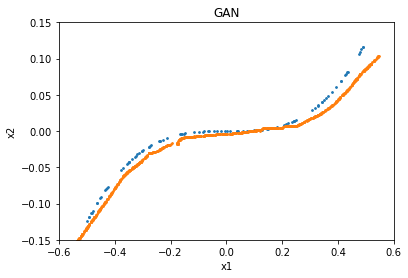

Epoch: 20000 	 Sinkhorn Divergence: 0.015834


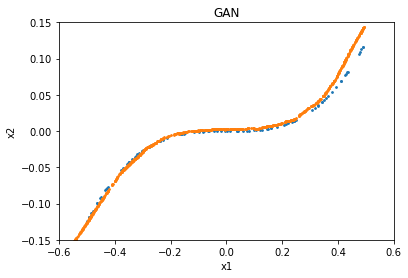

Epoch: 25000 	 Sinkhorn Divergence: 0.009805


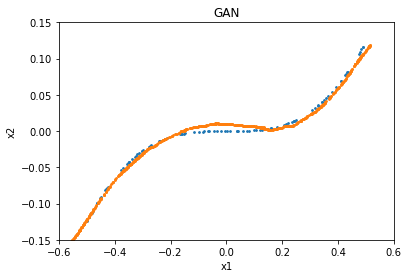

Epoch: 30000 	 Sinkhorn Divergence: 0.005273


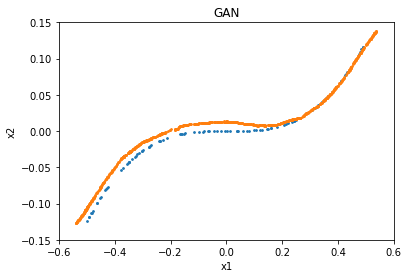

Epoch: 35000 	 Sinkhorn Divergence: 0.014721


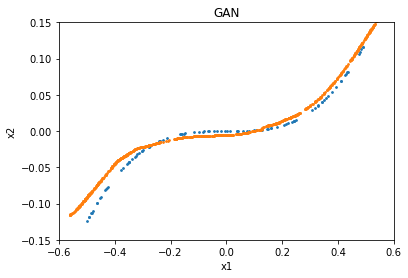

Epoch: 40000 	 Sinkhorn Divergence: 0.015058


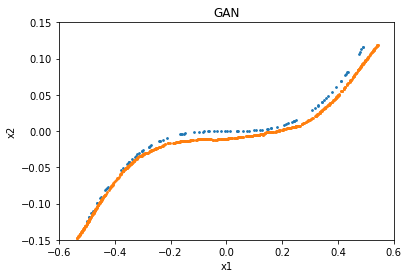

Epoch: 45000 	 Sinkhorn Divergence: 0.010403


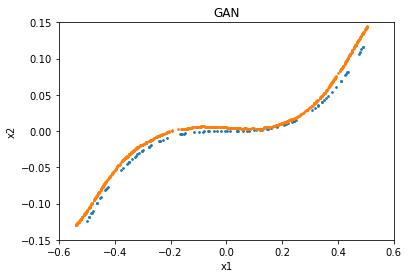

Epoch: 49999 	 Sinkhorn Divergence: 0.007784


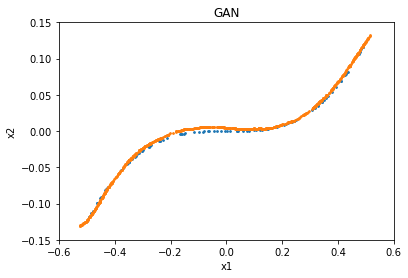

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = dataset_1D

epochs = 50000
batch_size = 100
latent_size = 1
out_feature = 2
width = 1024
eps = 0.05

dataloader = DataLoader(
    dataset.to(device), 
    batch_size, shuffle=True
    )
generator = Generator(latent_size, out_feature, width).to(device)
optimizer = Adam(generator.parameters(), lr=3e-4)


for epoch in range(epochs):
    for batch in dataloader:
        optimizer.zero_grad()
        noise = torch.rand(len(batch), latent_size, device=device)
        pred = generator(noise)
        sinkd = sinkhorn_divergence(
            torch.ones(len(batch), 1, device=device) / len(batch), 
            batch, 
            torch.ones(len(batch), 1, device=device) / len(batch), 
            pred,
            eps=eps, iter=1000
            )
        sinkm = - sinkhorn_divergence(
            torch.ones(batch_size, 1, device=device) / batch_size, 
            torch.hstack([noise[torch.randperm(len(noise))], pred]),
            torch.ones(batch_size, 1, device=device) / batch_size, 
            torch.hstack([noise, pred]),
            eps=eps, iter=1000
            )
        loss = sinkd + sinkm
        loss.backward()
        optimizer.step()

    if epoch % 5000 == 0 or epoch == epochs-1:
        print('Epoch: {} \t Sinkhorn Divergence: {:4f}'.format(epoch, sinkd.item()))
        record = generator(torch.rand(800, latent_size, device=device)).cpu().detach().numpy()
        plt.scatter(dataset[:, 0], dataset[:, 1], s=3)
        plt.scatter(record[:, 0], record[:, 1], s=3)
        plt.xlim(-0.6, 0.6); plt.ylim(-0.15, 0.15)
        plt.title('GAN')
        plt.xlabel('x1')
        plt.ylabel('x2')
        # plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

### Immersion $1\to 2$

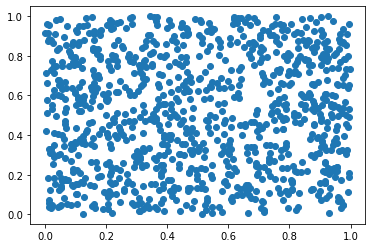

In [32]:
dataset_org = torch.rand(1000, 2)
plt.scatter(dataset_org[:,0], dataset_org[:, 1])
plt.show()

In [30]:
from scipy.stats import special_ortho_group

class NonlinearIsomorphism:
    def __init__(self, dimension, layers, activ=torch.tanh, inv_activ=torch.atanh):
        super().__init__()
        self.linears = [torch.tensor(special_ortho_group.rvs(dimension), dtype=torch.float) for _ in range(layers)]
        self.activ = activ
        self.inv_activ = inv_activ
    
    def forward(self, input):
        for linear in self.linears[:-1]:
            input = self.activ(input @ linear)
        return input @ self.linears[-1]
    
    def backward(self, input):
        for linear in self.linears[:0:-1]:
            input = self.inv_activ(torch.clip(input @ linear.inverse(), -1 + 1e-6, 1 - 1e-6))
        return input @ self.linears[0].inverse()

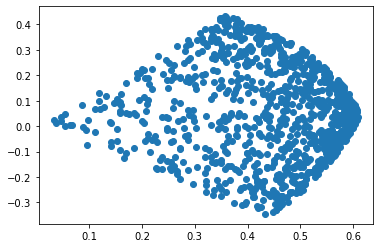

In [41]:
isom = NonlinearIsomorphism(2, 5)
dataset_2d = isom.forward(dataset_org)
plt.scatter(dataset_2d[:,0], dataset_2d[:, 1])
plt.show()

Epoch: 0 	 Sinkhorn Divergence: 0.307589


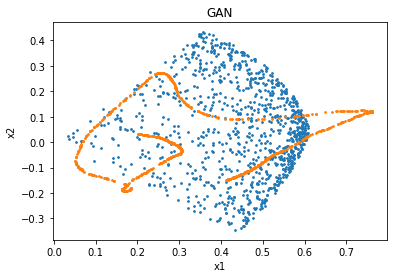

Epoch: 1000 	 Sinkhorn Divergence: 0.015400


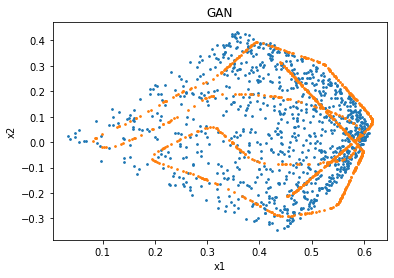

Epoch: 2000 	 Sinkhorn Divergence: 0.008421


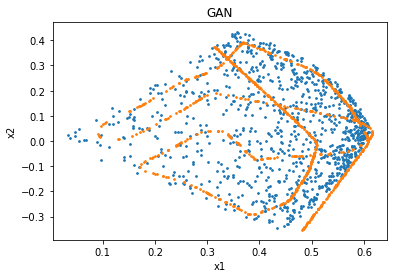

Epoch: 3000 	 Sinkhorn Divergence: 0.012903


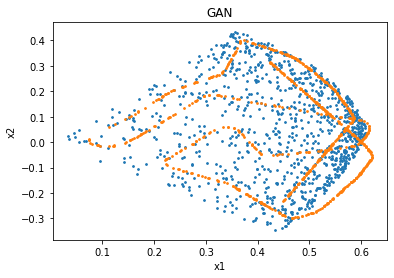

Epoch: 4000 	 Sinkhorn Divergence: 0.008718


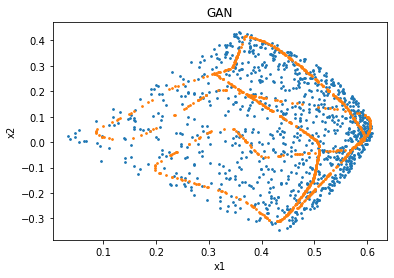

Epoch: 5000 	 Sinkhorn Divergence: 0.012736


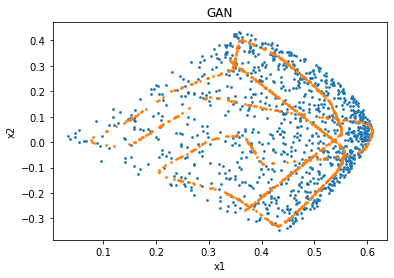

Epoch: 6000 	 Sinkhorn Divergence: 0.011211


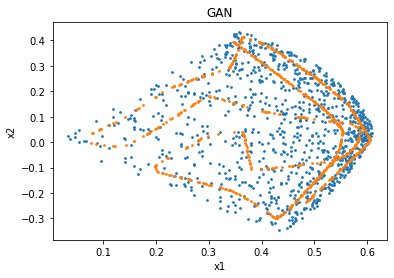

Epoch: 7000 	 Sinkhorn Divergence: 0.009688


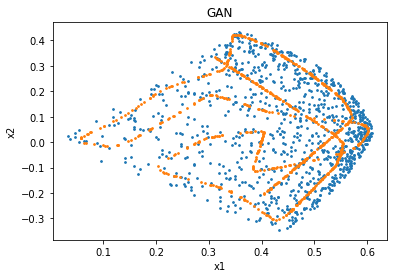

Epoch: 8000 	 Sinkhorn Divergence: 0.009189


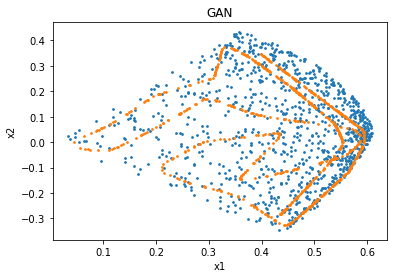

Epoch: 9000 	 Sinkhorn Divergence: 0.007664


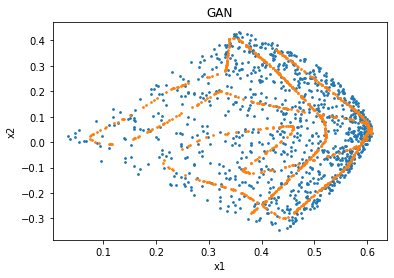

Epoch: 10000 	 Sinkhorn Divergence: 0.008385


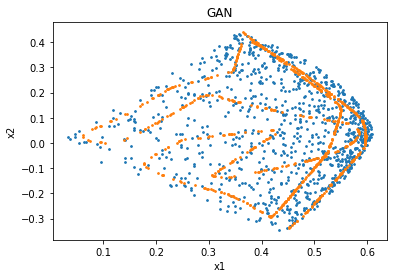

Epoch: 11000 	 Sinkhorn Divergence: 0.007252


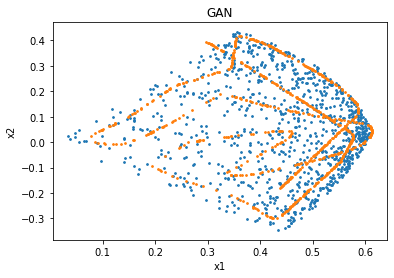

Epoch: 12000 	 Sinkhorn Divergence: 0.008420


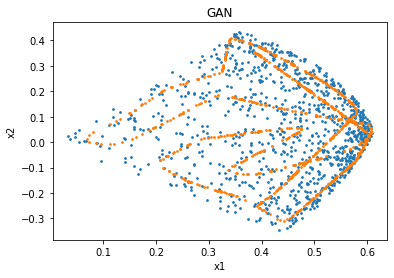

Epoch: 13000 	 Sinkhorn Divergence: 0.012210


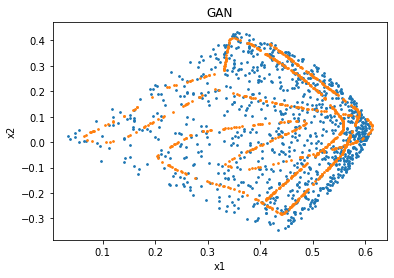

Epoch: 14000 	 Sinkhorn Divergence: 0.011769


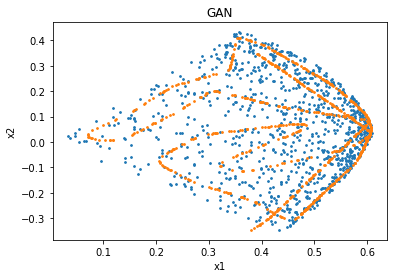

Epoch: 15000 	 Sinkhorn Divergence: 0.010109


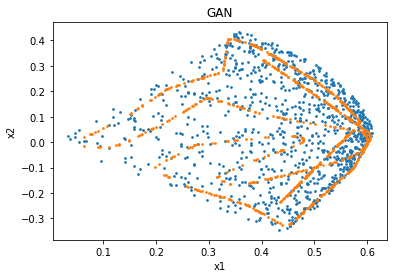

Epoch: 16000 	 Sinkhorn Divergence: 0.008693


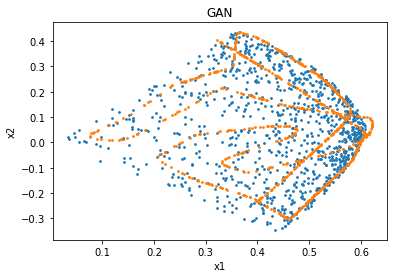

Epoch: 17000 	 Sinkhorn Divergence: 0.010373


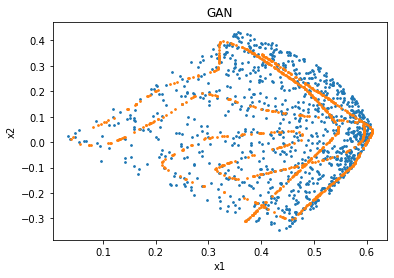

Epoch: 18000 	 Sinkhorn Divergence: 0.007110


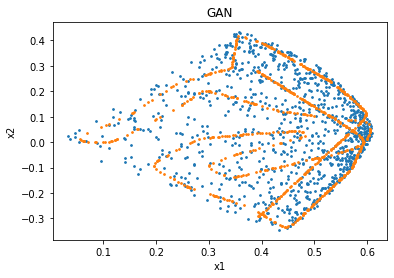

Epoch: 19000 	 Sinkhorn Divergence: 0.008802


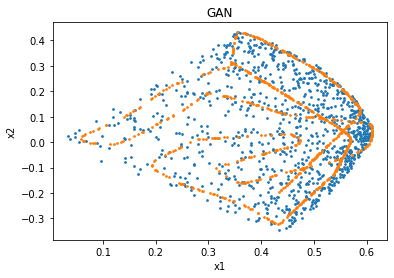

Epoch: 19999 	 Sinkhorn Divergence: 0.006929


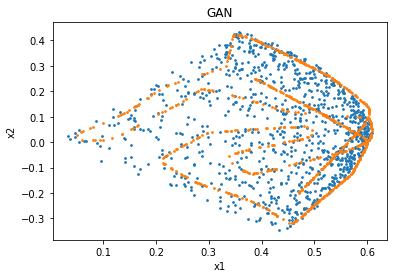

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = dataset_2d

epochs = 20000
batch_size = 250
latent_size = 1
out_feature = 2
width = 1024

dataloader = DataLoader(
    dataset.to(device), 
    batch_size, shuffle=True
    )
generator = Generator(latent_size, out_feature, width).to(device)
optimizer = Adam(generator.parameters(), lr=3e-4)


for epoch in range(epochs):
    for batch in dataloader:
        optimizer.zero_grad()
        loss = sinkhorn_divergence(
            torch.ones(len(batch), 1, device=device) / len(batch), 
            batch, 
            torch.ones(len(batch), 1, device=device) / len(batch), 
            generator(torch.rand(len(batch), latent_size, device=device)),
            eps=0.05, iter=1000
            )
        loss.backward()
        optimizer.step()

    if epoch % 1000 == 0 or epoch == epochs-1:
        print('Epoch: {} \t Sinkhorn Divergence: {:4f}'.format(epoch, loss.item()))
        record = generator(torch.rand(800, latent_size, device=device)).cpu().detach().numpy()
        plt.scatter(dataset[:, 0], dataset[:, 1], s=3)
        plt.scatter(record[:, 0], record[:, 1], s=3)
        # plt.xlim(-0.6, 0.6); plt.ylim(-0.15, 0.15)
        plt.title('GAN')
        plt.xlabel('x1')
        plt.ylabel('x2')
        # plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

Epoch: 0 	 Sinkhorn Divergence: 0.242316


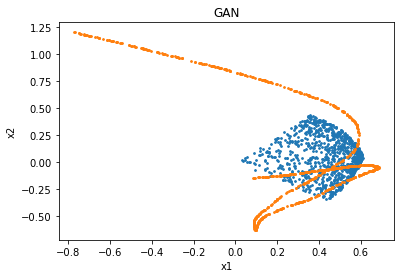

Epoch: 1000 	 Sinkhorn Divergence: 0.045084


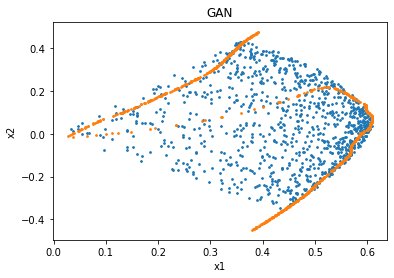

Epoch: 2000 	 Sinkhorn Divergence: 0.048113


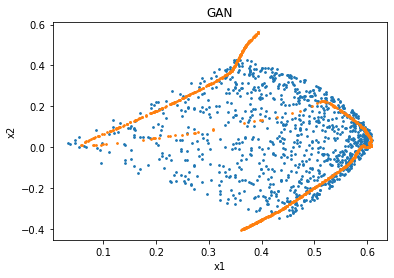

Epoch: 3000 	 Sinkhorn Divergence: 0.050313


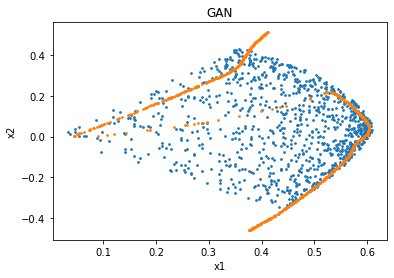

Epoch: 4000 	 Sinkhorn Divergence: 0.046965


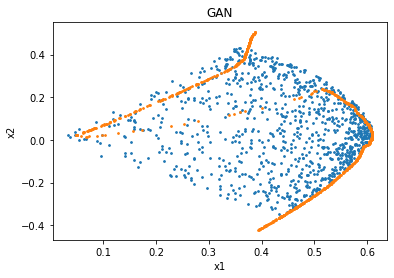

Epoch: 5000 	 Sinkhorn Divergence: 0.054326


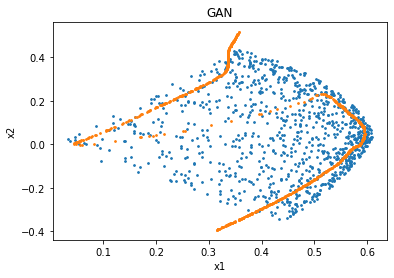

Epoch: 6000 	 Sinkhorn Divergence: 0.050761


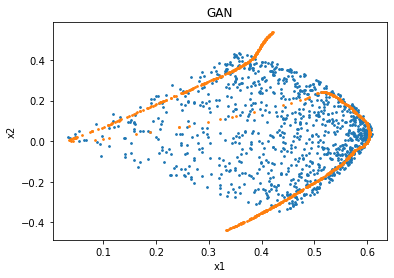

Epoch: 7000 	 Sinkhorn Divergence: 0.041606


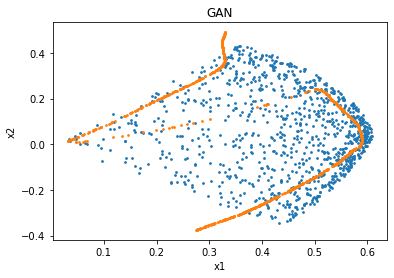

Epoch: 8000 	 Sinkhorn Divergence: 0.041762


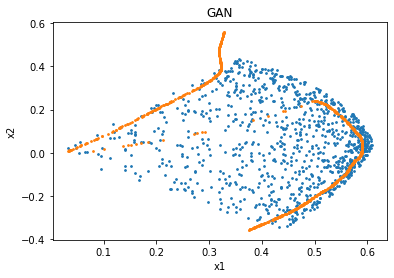

Epoch: 9000 	 Sinkhorn Divergence: 0.042081


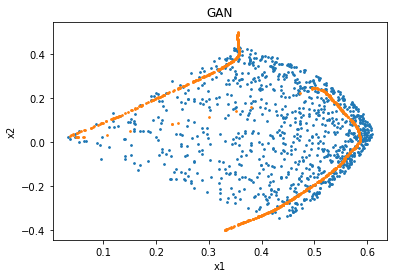

Epoch: 10000 	 Sinkhorn Divergence: 0.030072


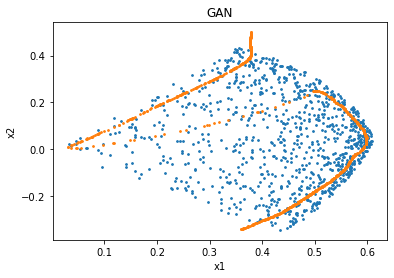

Epoch: 11000 	 Sinkhorn Divergence: 0.037937


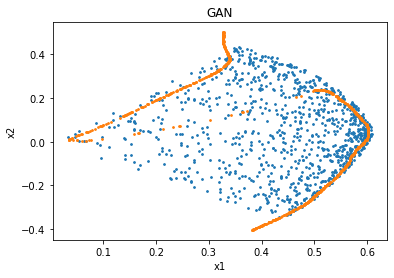

Epoch: 12000 	 Sinkhorn Divergence: 0.037138


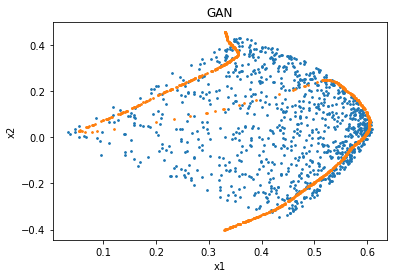

Epoch: 13000 	 Sinkhorn Divergence: 0.034429


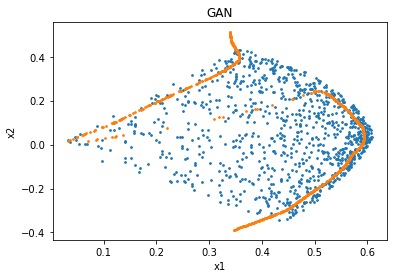

Epoch: 14000 	 Sinkhorn Divergence: 0.036756


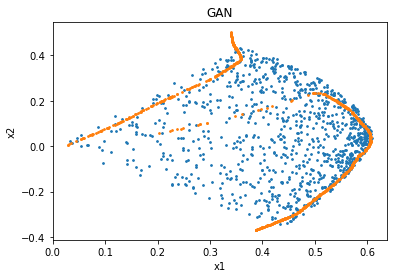

Epoch: 15000 	 Sinkhorn Divergence: 0.036475


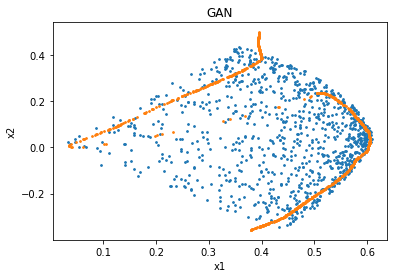

Epoch: 16000 	 Sinkhorn Divergence: 0.038837


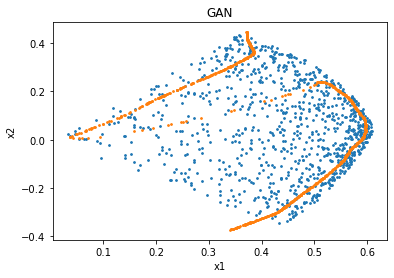

Epoch: 17000 	 Sinkhorn Divergence: 0.029707


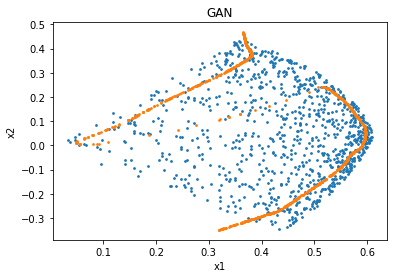

Epoch: 18000 	 Sinkhorn Divergence: 0.034447


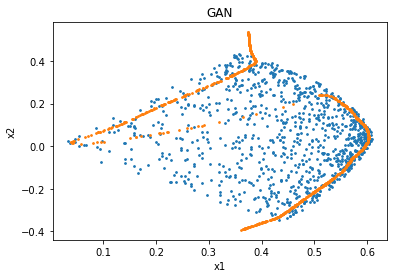

Epoch: 19000 	 Sinkhorn Divergence: 0.029934


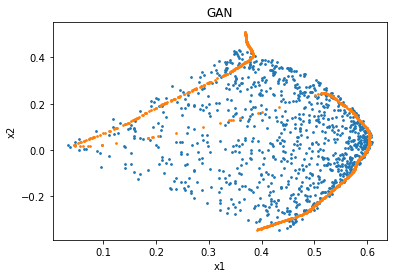

Epoch: 19999 	 Sinkhorn Divergence: 0.042729


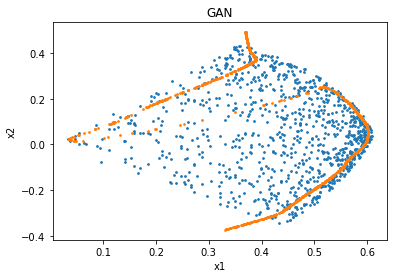

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = dataset_2d

epochs = 20000
batch_size = 250
latent_size = 1
out_feature = 2
width = 1024
eps = 0.05

dataloader = DataLoader(
    dataset.to(device), 
    batch_size, shuffle=True
    )
generator = Generator(latent_size, out_feature, width).to(device)
optimizer = Adam(generator.parameters(), lr=3e-4)


for epoch in range(epochs):
    for batch in dataloader:
        optimizer.zero_grad()
        noise = torch.rand(len(batch), latent_size, device=device)
        pred = generator(noise)
        sinkd = sinkhorn_divergence(
            torch.ones(len(batch), 1, device=device) / len(batch), 
            batch, 
            torch.ones(len(batch), 1, device=device) / len(batch), 
            pred,
            eps=eps, iter=1000
            )
        sinkm = - sinkhorn_divergence(
            torch.ones(batch_size, 1, device=device) / batch_size, 
            torch.hstack([noise[torch.randperm(len(noise))], pred]),
            torch.ones(batch_size, 1, device=device) / batch_size, 
            torch.hstack([noise, pred]),
            eps=eps, iter=1000
            )
        loss = sinkd + sinkm
        loss.backward()
        optimizer.step()

    if epoch % 1000 == 0 or epoch == epochs-1:
        print('Epoch: {} \t Sinkhorn Divergence: {:4f}'.format(epoch, sinkd.item()))
        record = generator(torch.rand(800, latent_size, device=device)).cpu().detach().numpy()
        plt.scatter(dataset[:, 0], dataset[:, 1], s=3)
        plt.scatter(record[:, 0], record[:, 1], s=3)
        # plt.xlim(-0.6, 0.6); plt.ylim(-0.15, 0.15)
        plt.title('GAN')
        plt.xlabel('x1')
        plt.ylabel('x2')
        # plt.gca().set_aspect('equal', adjustable='box')
        plt.show()